#Set-Up

Importing necessary libraries and uploading the csv file into colab

In [23]:
#Preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#classifiers and performance metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

Loading the Data

In [3]:
from google.colab import files

uploaded = files.upload()

Saving data.csv to data.csv


#Global Settings for Visualisations

In [24]:
labelsize = 15

plt.rcParams['figure.figsize'] = 15,12
plt.rcParams["axes.titlesize"]= labelsize*0.8
plt.rcParams["axes.labelsize"]=labelsize
plt.rcParams["lines.linewidth"]=0.5
plt.rcParams["lines.markersize"]=5
plt.rcParams["xtick.labelsize"]=labelsize*0.8
plt.rcParams["ytick.labelsize"]=labelsize*0.8
plt.rcParams["font.family"] = "monospace"
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams["legend.fontsize"] = labelsize*0.6
plt.rcParams["legend.frameon"] = False
plt.rcParams["legend.title_fontsize"] = labelsize*0.6
plt.style.use('ggplot')

# EDA

In [25]:
df = pd.read_csv('data.csv')

Loading the csv file into pandas dataframe for further converting it into a numpy array

In [26]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [27]:
#drop irrelevant column : id

df.drop(['id', 'Unnamed: 32'], axis = 1, inplace = True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [29]:
# Splitting dataset into independent & dependent datasets

X = df.drop('diagnosis', axis = 1)
Y = df['diagnosis']

In [30]:
def violinplot(data_norm, data_diag, start_idx, stop_idx):
    data = pd.concat([data_diag,data_norm.iloc[:,start_idx:stop_idx]],axis=1)
    data = pd.melt(data,id_vars="diagnosis",
                        var_name="features",
                        value_name='value')
    sns.violinplot(x="features", y="value", hue="diagnosis", data=data,split=True, inner="quart")
    plt.xticks(rotation=90)
    plt.show()

In [31]:
# Prepare data for violin plot visualisation
data_diag = Y
data = X
data_norm = (data - data.mean()) / (data.std())   

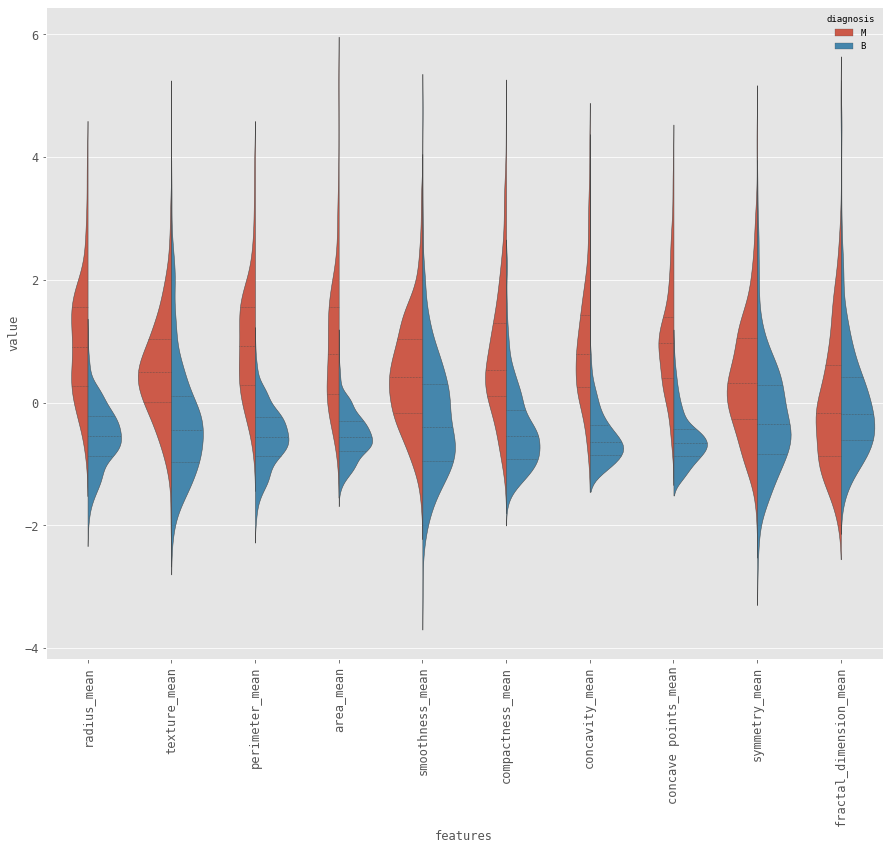

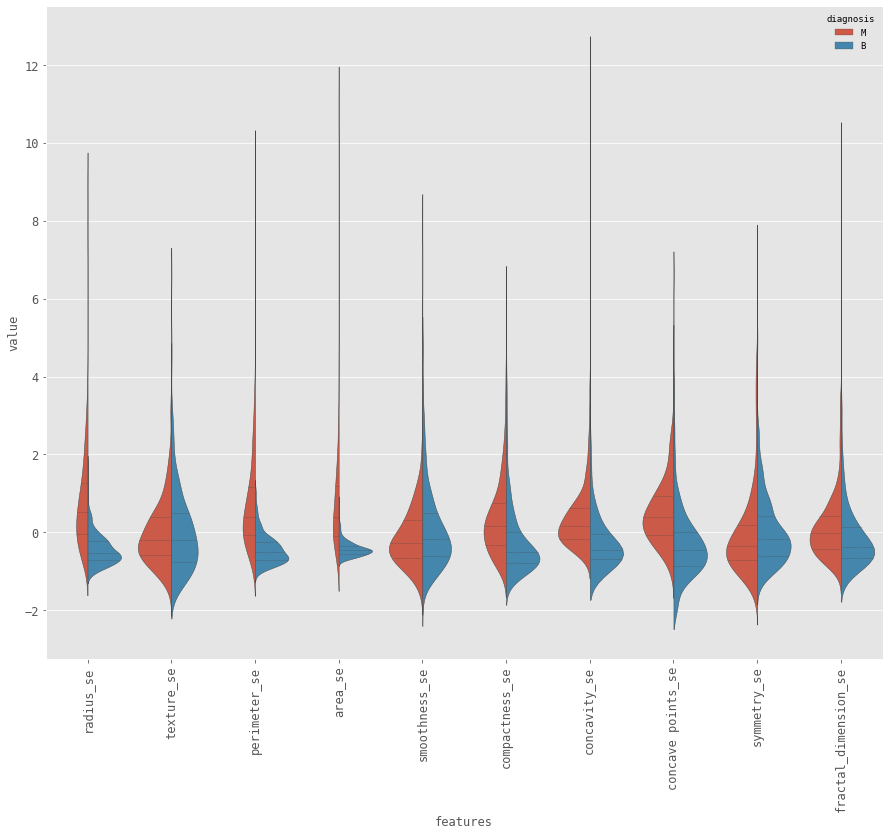

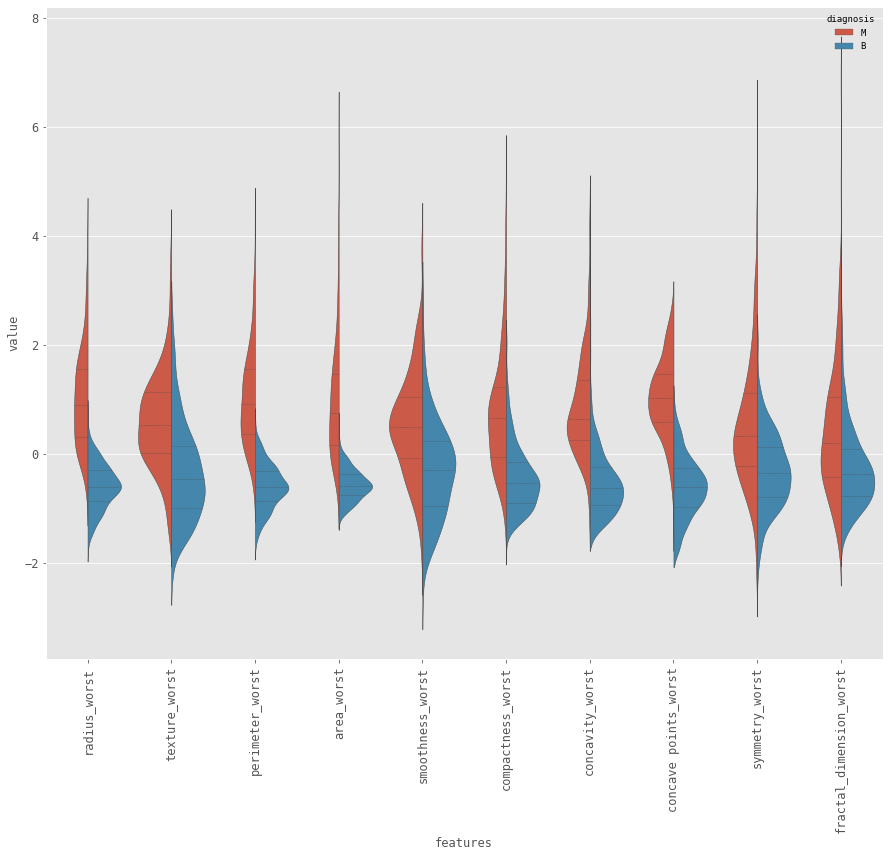

In [32]:
violinplot(data_norm, data_diag, 0, 10)
violinplot(data_norm, data_diag, 10, 20)
violinplot(data_norm, data_diag, 20, 30)

The above plots shows which variables have distinct distributions under M and B conditions, and so we rely on such variables for the classification. For eg., radius_se

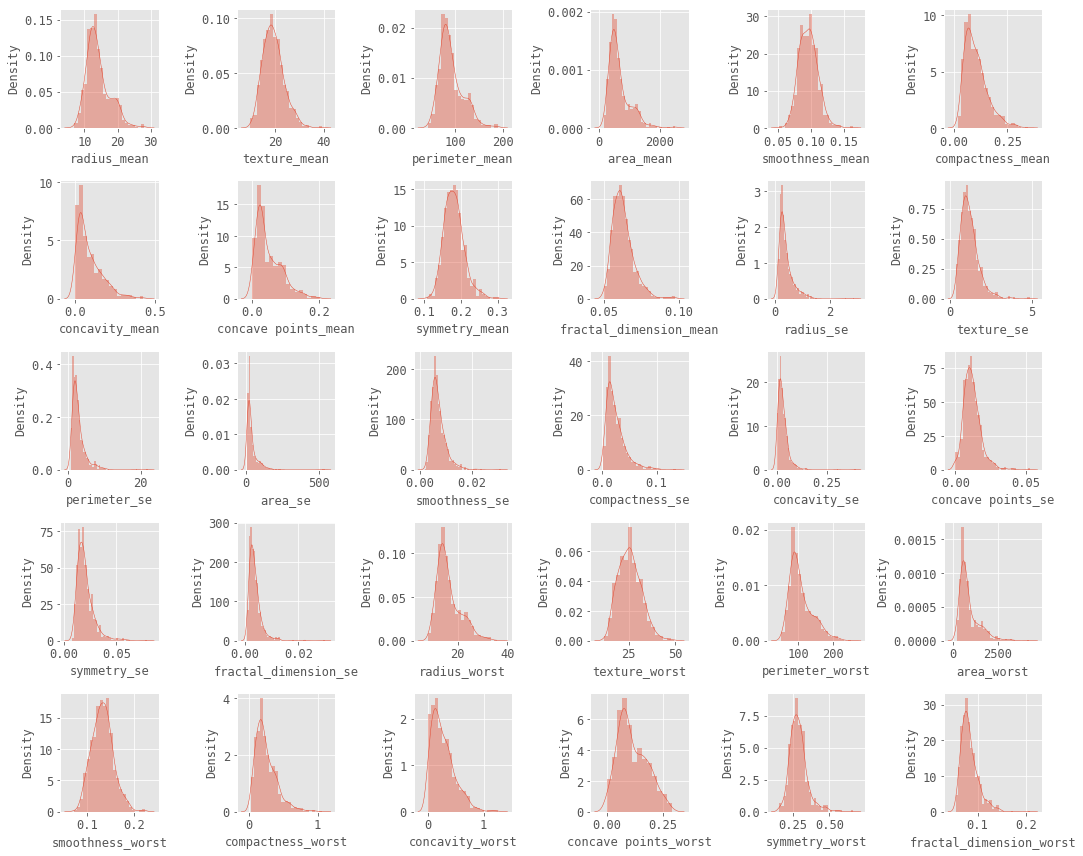

In [33]:
# Data distribution
plotnumber = 1
for column in X:
    if plotnumber <= 30:
        ax = plt.subplot(5, 6, plotnumber)
        sns.distplot(X[column])
        plt.xlabel(column)
        
    plotnumber += 1

plt.tight_layout()
plt.show()

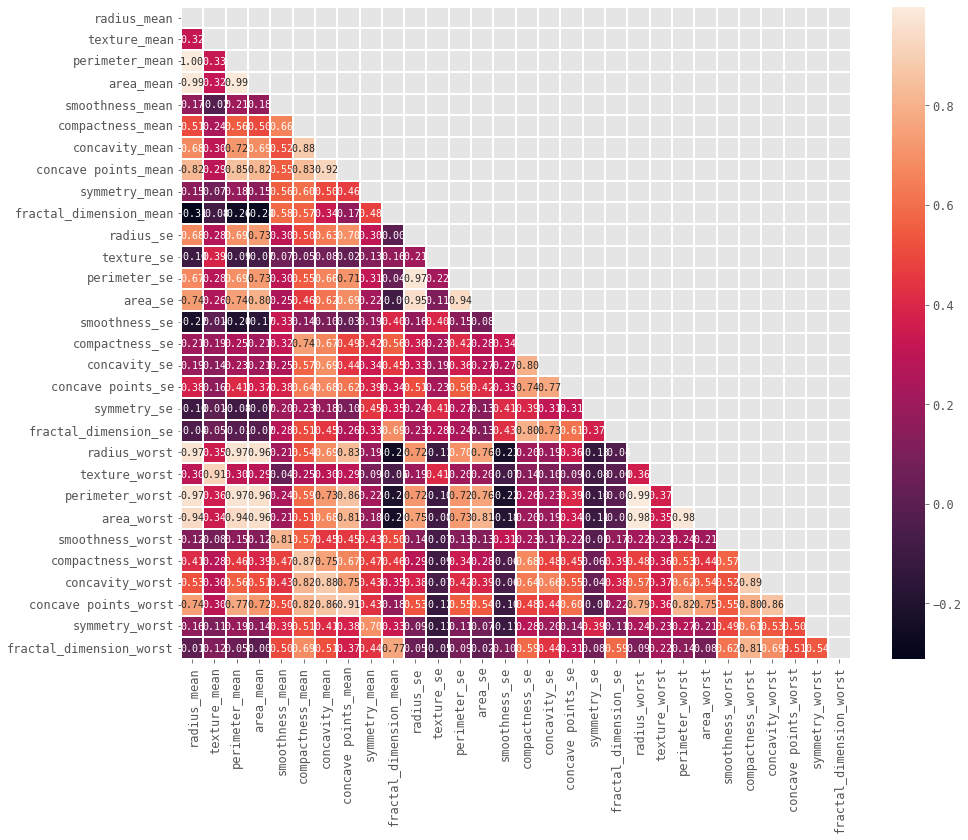

In [34]:
# Correlations 
corr = X.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, linewidths = 1, annot = True, fmt = ".2f")
plt.show()

You can clearly see that several columns are very highly correlated, causing multicollinearity among independent variables. We need to remove the highly correlated features in the preprocessing steps.

#Data Preprocessing

Label Encoding

In [35]:
# convert labels to machine readable (numerical) form
df.dtypes

diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst

In [36]:
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [37]:
labelencoder = LabelEncoder()

In [39]:
df['diagnosis'] = labelencoder.fit_transform(df['diagnosis'].values)

In [40]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Remove highly correlated features


In [43]:
# Splitting the pre-processed data into independent & dependent variables for further processing
X = df.drop('diagnosis', axis = 1)
Y = df['diagnosis']

In [44]:
# removing highly correlated features
corr_matrix = X.corr().abs() 

mask = np.triu(np.ones_like(corr_matrix, dtype = bool))
tri_df = corr_matrix.mask(mask)
to_drop = [x for x in tri_df.columns if any(tri_df[x] > 0.85)]
df = df.drop(to_drop, axis = 1)

print(f"The reduced dataframe has {df.shape[1]} columns.")

The reduced dataframe has 18 columns.


Remove remaining Null Values

In [45]:
# drop any null values
X.dropna(axis=1, inplace=True)

In [46]:
X.isna().sum()

smoothness_mean            0
symmetry_mean              0
fractal_dimension_mean     0
texture_se                 0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
texture_worst              0
area_worst                 0
smoothness_worst           0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [47]:
# Split dataset into training(75%) and testing(25%)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.25,random_state = 1)

In [48]:
# scale data to be within a certain range
sc = StandardScaler()
X_train = sc.fit_transform(X_train) # fit method: learns about data, transform: uses (x-mean)/sd to transform data into a zero mean varance 1 range
X_test = sc.transform(X_test) # use mean and sd obtained in previous step

#Logistic Regression

In [49]:
# Build a logistic regression classifier
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train,Y_train)

LogisticRegression(random_state=0)

In [50]:
Y_predictions = classifier.predict(X_test)

In [51]:
Y_predictions

array([0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0])

In [52]:
Y_test.values

array([0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0])

#Performance Evaluation

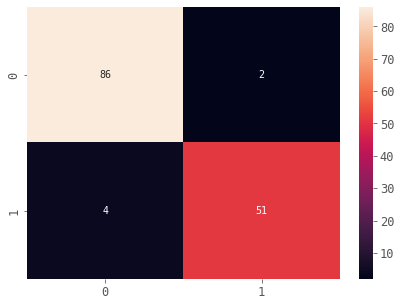

In [54]:
# Confusion matrix
plt.figure(figsize=(7,5))
cm = confusion_matrix(Y_test, Y_predictions)
sns.heatmap(cm, annot=True)

In [55]:
# Accuracy score for model
print(accuracy_score(Y_train, classifier.predict(X_train)))

log_reg_acc = accuracy_score(Y_test, classifier.predict(X_test))
print(log_reg_acc)

0.9882629107981221
0.958041958041958


In [56]:
# classification report
print(classification_report(Y_test, Y_predictions))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        88
           1       0.96      0.93      0.94        55

    accuracy                           0.96       143
   macro avg       0.96      0.95      0.96       143
weighted avg       0.96      0.96      0.96       143

